latent features of cover and mark images computed which are concatenated via embedder network
The encoder progressively decreases the size of the cover image 
feature map to make it equal to the mark feature map so that the feature maps of WZ and CZ can be concatenated.

the decoder progressively increases the feature 
map to obtain the marked imag
the decoder network learns a decoding function to decode the concatenated feature to obtain the marked image



In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

from skimage.metrics import peak_signal_noise_ratio as sk_psnr, structural_similarity as sk_ssim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
#initialize 
batch_size = 32
learning_rate = 0.0001
num_epochs = 300
num_kernels = 32   
kernel_size = 3    

In [3]:
#Making directories
os.makedirs("data/raw/cats_dogs",exist_ok=True)
os.makedirs("data/raw/cifar",exist_ok=True)
os.makedirs("data/preprocessed/covers/train", exist_ok=True)
os.makedirs("data/preprocessed/covers/test", exist_ok=True)
os.makedirs("data/preprocessed/watermarks/train", exist_ok=True)
os.makedirs("data/preprocessed/watermarks/test", exist_ok=True)


In [4]:
#Loading Watermark dataset W using torchvision
import torchvision
from torchvision import transforms

transform=transforms.Compose([
    transforms.ToTensor(),
])

cifar_train=torchvision.datasets.CIFAR10(root='data/raw/cifar',train=True,download=True,transform=transform)
cifar_test = torchvision.datasets.CIFAR10(root='data/raw/cifar', train=False, download=True, transform=transform)

print("CIFAR-10 download complete!")

100%|██████████| 170M/170M [19:43<00:00, 144kB/s]    


CIFAR-10 download complete!


In [5]:
#preprocessing cats and dogs
from PIL import Image
import random

cat_dir = "data/raw/cats_dogs/PetImages/Cat"
dog_dir = "data/raw/cats_dogs/PetImages/Dog"

all_images = []

for label, folder in [("cat", cat_dir), ("dog", dog_dir)]:
    for fname in os.listdir(folder):#os.listdir(folder) returns all file names found in the given path.
        if fname.lower().endswith(('.jpg')):
            all_images.append((label, os.path.join(folder, fname)))

random.seed(42)
random.shuffle(all_images)

train_images = all_images[:10000]
test_images = all_images[10000:18000]

def preprocess_and_save(images, target_folder):
    os.makedirs(target_folder, exist_ok=True)
    for idx, (label, path) in enumerate(images):
        try:
            img = Image.open(path).convert('L').resize((128, 128))
            save_path = os.path.join(target_folder, f"{label}_{idx:05d}.png")
            img.save(save_path)
        except Exception as e:
            print(f"Skipping {path} due to {e}")

preprocess_and_save(train_images, "data/preprocessed/covers/train")
preprocess_and_save(test_images, "data/preprocessed/covers/test")

print("Cats & Dogs preprocessing complete.")


Skipping data/raw/cats_dogs/PetImages/Dog\11702.jpg due to cannot identify image file 'C:\\Users\\parni\\Desktop\\Watermarking Project\\data\\raw\\cats_dogs\\PetImages\\Dog\\11702.jpg'
Skipping data/raw/cats_dogs/PetImages/Cat\666.jpg due to cannot identify image file 'C:\\Users\\parni\\Desktop\\Watermarking Project\\data\\raw\\cats_dogs\\PetImages\\Cat\\666.jpg'
Cats & Dogs preprocessing complete.


In [7]:
def save_cifar_images(cifar_data, target_folder, max_images):
    os.makedirs(target_folder, exist_ok=True)
    count = 0
    for img_array, _ in cifar_data:
        if count >= max_images:
            break
        if isinstance(img_array, torch.Tensor):
            arr = (img_array.permute(1,2,0).numpy() * 255).astype('uint8')
            img = Image.fromarray(arr)
        elif isinstance(img_array, Image.Image):
            img = img_array
        else:
            img = Image.fromarray(img_array)
        img = img.convert('L').resize((32,32))
        img.save(os.path.join(target_folder, f"wm_{count:04d}.png"))
        count += 1

#Converting to tensor is for deep learning.
#Converting back to numpy/PIL is for saving and viewing.

save_cifar_images(cifar_train, "data/preprocessed/watermarks/train", 1000)
save_cifar_images(cifar_test, "data/preprocessed/watermarks/test", 600)

print("CIFAR-10 watermark preprocessing complete.")


CIFAR-10 watermark preprocessing complete.


Returns (cover_tensor, watermark_tensor).
Cover is resized to cover_size (default 128), watermark to wm_size (default 32).
Both are grayscale [1, H, W] tensors in [0,1].
Files are paired by sorted order to preserve deterministic pairing.

In [5]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

class PairedCoverWatermarkDataset(Dataset):    
    def __init__(self, cover_dir, wm_dir, cover_size, wm_size):
        self.cover_dir = Path(cover_dir)
        self.wm_dir = Path(wm_dir)
        self.covers = sorted([p for p in self.cover_dir.glob("*") if p.suffix.lower() in [".png", ".jpg", ".jpeg"]])
        self.wms = sorted([p for p in self.wm_dir.glob("*") if p.suffix.lower() in [".png", ".jpg", ".jpeg"]])

        self.cover_transform = transforms.Compose([
            transforms.Resize((cover_size, cover_size)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
        self.wm_transform = transforms.Compose([
            transforms.Resize((wm_size, wm_size)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.covers)

    def __getitem__(self, idx):
        cover_path = self.covers[idx]
        wm_path = self.wms[idx % len(self.wms)]

        cover = Image.open(cover_path).convert("L")
        wm = Image.open(wm_path).convert("L")

        cover_t = self.cover_transform(cover)   
        wm_t = self.wm_transform(wm)            

        return cover_t, wm_t

# Create instances and dataloaders using your hyperparameters
COVER_SIZE = 128
WM_SIZE = 32

train_dataset = PairedCoverWatermarkDataset('data/preprocessed/covers/train','data/preprocessed/watermarks/train', cover_size=COVER_SIZE, wm_size=WM_SIZE)
test_dataset = PairedCoverWatermarkDataset('data/preprocessed/covers/test', 'data/preprocessed/watermarks/test', cover_size=COVER_SIZE, wm_size=WM_SIZE)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0)


print("Train samples:", len(train_dataset), "Test samples:", len(test_dataset))
print("Example shapes (cover, wm):", next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape)


Train samples: 9998 Test samples: 8000
Example shapes (cover, wm): torch.Size([32, 1, 128, 128]) torch.Size([32, 1, 32, 32])


Conv2d extracts features
BatchNorm keeps those features stable
ReLU helps the network learn complex mappings

nn.MaxPool2d(2)
Reduces spatial resolution from 128→64
Keeps strongest patterns/features
Helps the network look at bigger regions (increases receptive field)

In [3]:
import torch.nn as nn
import torch.nn.functional as F

Num_kernels = globals().get("num_kernels", 64)
kernel_size = globals().get("kernel_size", 3)

def conv_block(in_ch, out_ch, k=kernel_size, stride=1, padding=None):
    if padding is None:
        padding = k // 2
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, k, stride=stride, padding=padding),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )

class CoverEncoder(nn.Module):
    def __init__(self, in_channels=1, base_channels=Num_kernels):
        super().__init__()
        # two convs before each pooling: conv(in->C), conv(C->C)
        self.enc = nn.Sequential(
            conv_block(in_channels, base_channels),
            conv_block(base_channels, base_channels),       
            nn.MaxPool2d(2),                              #128->64

            conv_block(base_channels, base_channels*2),
            conv_block(base_channels*2, base_channels*2),
            nn.MaxPool2d(2),                              # 64->32

            conv_block(base_channels*2, base_channels*4),
            conv_block(base_channels*4, base_channels*4),
            nn.MaxPool2d(2),                              # 32->16
        )

    def forward(self, x):
        return self.enc(x)


class WatermarkEncoder(nn.Module):
    def __init__(self, in_channels=1, base_channels=Num_kernels):
        super().__init__()
        self.enc = nn.Sequential(
            conv_block(in_channels, base_channels),
            conv_block(base_channels, base_channels),
            nn.MaxPool2d(2),   # 32 -> 16

            conv_block(base_channels, base_channels*2),
            conv_block(base_channels*2, base_channels*2),
            # no further pool
        )

    def forward(self, x):
        return self.enc(x)



class EmbedderDecoder(nn.Module):
    def __init__(self, out_channels=1, base_channels=Num_kernels):
        super().__init__()

        # total input channels = cover (4*base) + wm (2*base) = 6*base
        in_ch = base_channels * 6

        self.dec = nn.Sequential(
            conv_block(in_ch, base_channels*4),
            conv_block(base_channels*4, base_channels*4),
            nn.Upsample(scale_factor=2),

            conv_block(base_channels*4, base_channels*2),
            conv_block(base_channels*2, base_channels*2),
            nn.Upsample(scale_factor=2),

            conv_block(base_channels*2, base_channels),
            conv_block(base_channels, base_channels),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(base_channels, out_channels, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.dec(x)



class WatermarkEmbedder(nn.Module):
    def __init__(self, base_channels=Num_kernels):
        super().__init__()
        self.enc_c = CoverEncoder(in_channels=1, base_channels=base_channels)
        self.enc_w = WatermarkEncoder(in_channels=1, base_channels=base_channels)
        self.decoder = EmbedderDecoder(out_channels=1, base_channels=base_channels)

    def forward(self, cover, watermark):
        zc = self.enc_c(cover)       # [B, Cc, 16,16]
        zw = self.enc_w(watermark)   # [B, Cw, 16,16]
        z = torch.cat([zc, zw], dim=1)  # [B, Cc+Cw, 16,16]
        marked = self.decoder(z)        # [B,1,128,128], values in [0,1]
        return marked

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedder = WatermarkEmbedder(base_channels=Num_kernels).to(device)
dummy_cover = torch.randn(2,1,128,128).to(device)
dummy_wm = torch.randn(2,1,32,32).to(device)
with torch.no_grad():
    out = embedder(dummy_cover, dummy_wm)
print("Embedder output shape:", out.shape)


Embedder output shape: torch.Size([2, 1, 128, 128])


Epoch 1/60: 100%|██████████| 312/312 [08:55<00:00,  1.72s/it, loss=0.00668]



Epoch 1: Train Loss = 0.008386, Val Loss = 0.006184


Epoch 2/60: 100%|██████████| 312/312 [08:27<00:00,  1.63s/it, loss=0.00511]



Epoch 2: Train Loss = 0.004907, Val Loss = 0.004182


Epoch 3/60: 100%|██████████| 312/312 [08:21<00:00,  1.61s/it, loss=0.00337]



Epoch 3: Train Loss = 0.004254, Val Loss = 0.003640


Epoch 4/60: 100%|██████████| 312/312 [08:29<00:00,  1.63s/it, loss=0.00463]



Epoch 4: Train Loss = 0.003955, Val Loss = 0.003609


Epoch 5/60: 100%|██████████| 312/312 [09:03<00:00,  1.74s/it, loss=0.00509]



Epoch 5: Train Loss = 0.003674, Val Loss = 0.003730


Epoch 6/60: 100%|██████████| 312/312 [08:06<00:00,  1.56s/it, loss=0.00383]



Epoch 6: Train Loss = 0.003510, Val Loss = 0.005164


Epoch 7/60: 100%|██████████| 312/312 [07:41<00:00,  1.48s/it, loss=0.0028] 



Epoch 7: Train Loss = 0.003311, Val Loss = 0.002956


Epoch 8/60: 100%|██████████| 312/312 [07:46<00:00,  1.50s/it, loss=0.0027] 



Epoch 8: Train Loss = 0.003144, Val Loss = 0.003633


Epoch 9/60: 100%|██████████| 312/312 [07:41<00:00,  1.48s/it, loss=0.00343]



Epoch 9: Train Loss = 0.003021, Val Loss = 0.002732


Epoch 10/60: 100%|██████████| 312/312 [07:42<00:00,  1.48s/it, loss=0.00315]



Epoch 10: Train Loss = 0.002878, Val Loss = 0.002869


Epoch 11/60: 100%|██████████| 312/312 [07:43<00:00,  1.49s/it, loss=0.00312]



Epoch 11: Train Loss = 0.002835, Val Loss = 0.002683


Epoch 12/60: 100%|██████████| 312/312 [07:42<00:00,  1.48s/it, loss=0.00285]



Epoch 12: Train Loss = 0.002695, Val Loss = 0.003311


Epoch 13/60: 100%|██████████| 312/312 [07:41<00:00,  1.48s/it, loss=0.00241]



Epoch 13: Train Loss = 0.002638, Val Loss = 0.003904


Epoch 14/60: 100%|██████████| 312/312 [07:47<00:00,  1.50s/it, loss=0.00242]



Epoch 14: Train Loss = 0.002482, Val Loss = 0.002282


Epoch 15/60: 100%|██████████| 312/312 [07:37<00:00,  1.47s/it, loss=0.00285]



Epoch 15: Train Loss = 0.002421, Val Loss = 0.002272


Epoch 16/60: 100%|██████████| 312/312 [1:24:44<00:00, 16.30s/it, loss=0.00228]    



Epoch 16: Train Loss = 0.002332, Val Loss = 0.002204


Epoch 17/60: 100%|██████████| 312/312 [08:55<00:00,  1.72s/it, loss=0.00233]



Epoch 17: Train Loss = 0.002331, Val Loss = 0.002402


Epoch 18/60: 100%|██████████| 312/312 [09:11<00:00,  1.77s/it, loss=0.00241]



Epoch 18: Train Loss = 0.002274, Val Loss = 0.002241


Epoch 19/60: 100%|██████████| 312/312 [08:45<00:00,  1.68s/it, loss=0.00237]



Epoch 19: Train Loss = 0.002242, Val Loss = 0.002284


Epoch 20/60: 100%|██████████| 312/312 [07:36<00:00,  1.46s/it, loss=0.00267]



Epoch 20: Train Loss = 0.002154, Val Loss = 0.002074


Epoch 21/60: 100%|██████████| 312/312 [07:53<00:00,  1.52s/it, loss=0.00219]



Epoch 21: Train Loss = 0.002080, Val Loss = 0.001963


Epoch 22/60: 100%|██████████| 312/312 [07:15<00:00,  1.40s/it, loss=0.00166]



Epoch 22: Train Loss = 0.002059, Val Loss = 0.002032


Epoch 23/60: 100%|██████████| 312/312 [06:52<00:00,  1.32s/it, loss=0.00218]



Epoch 23: Train Loss = 0.002039, Val Loss = 0.001967


Epoch 24/60: 100%|██████████| 312/312 [06:52<00:00,  1.32s/it, loss=0.002]  



Epoch 24: Train Loss = 0.002008, Val Loss = 0.001869


Epoch 25/60: 100%|██████████| 312/312 [06:51<00:00,  1.32s/it, loss=0.00168]



Epoch 25: Train Loss = 0.001948, Val Loss = 0.001892


Epoch 26/60: 100%|██████████| 312/312 [07:16<00:00,  1.40s/it, loss=0.00181]



Epoch 26: Train Loss = 0.001945, Val Loss = 0.001986


Epoch 27/60: 100%|██████████| 312/312 [06:58<00:00,  1.34s/it, loss=0.0018] 



Epoch 27: Train Loss = 0.001901, Val Loss = 0.002017


Epoch 28/60: 100%|██████████| 312/312 [08:31<00:00,  1.64s/it, loss=0.00158]



Epoch 28: Train Loss = 0.001877, Val Loss = 0.001805


Epoch 29/60: 100%|██████████| 312/312 [08:01<00:00,  1.54s/it, loss=0.00227]



Epoch 29: Train Loss = 0.001862, Val Loss = 0.001895


Epoch 30/60: 100%|██████████| 312/312 [07:55<00:00,  1.52s/it, loss=0.00177]



Epoch 30: Train Loss = 0.001858, Val Loss = 0.001912


Epoch 31/60: 100%|██████████| 312/312 [07:56<00:00,  1.53s/it, loss=0.00183]



Epoch 31: Train Loss = 0.001820, Val Loss = 0.002305


Epoch 32/60: 100%|██████████| 312/312 [1:52:19<00:00, 21.60s/it, loss=0.00176]     



Epoch 32: Train Loss = 0.001792, Val Loss = 0.001691


Epoch 33/60: 100%|██████████| 312/312 [08:25<00:00,  1.62s/it, loss=0.00171]



Epoch 33: Train Loss = 0.001769, Val Loss = 0.001737


Epoch 34/60: 100%|██████████| 312/312 [08:07<00:00,  1.56s/it, loss=0.00159]



Epoch 34: Train Loss = 0.001751, Val Loss = 0.001980


Epoch 35/60: 100%|██████████| 312/312 [08:36<00:00,  1.66s/it, loss=0.00203]



Epoch 35: Train Loss = 0.001736, Val Loss = 0.001672


Epoch 36/60: 100%|██████████| 312/312 [08:33<00:00,  1.65s/it, loss=0.00182]



Epoch 36: Train Loss = 0.001720, Val Loss = 0.001686


Epoch 37/60: 100%|██████████| 312/312 [06:51<00:00,  1.32s/it, loss=0.00206]



Epoch 37: Train Loss = 0.001687, Val Loss = 0.001677


Epoch 38/60: 100%|██████████| 312/312 [06:26<00:00,  1.24s/it, loss=0.00151]



Epoch 38: Train Loss = 0.001696, Val Loss = 0.001600


Epoch 39/60: 100%|██████████| 312/312 [06:30<00:00,  1.25s/it, loss=0.00145]



Epoch 39: Train Loss = 0.001678, Val Loss = 0.002041


Epoch 40/60: 100%|██████████| 312/312 [06:39<00:00,  1.28s/it, loss=0.00164]



Epoch 40: Train Loss = 0.001672, Val Loss = 0.001583


Epoch 41/60: 100%|██████████| 312/312 [06:37<00:00,  1.27s/it, loss=0.00162]



Epoch 41: Train Loss = 0.001655, Val Loss = 0.001570


Epoch 42/60: 100%|██████████| 312/312 [07:05<00:00,  1.36s/it, loss=0.00145]



Epoch 42: Train Loss = 0.001611, Val Loss = 0.001637


Epoch 43/60: 100%|██████████| 312/312 [07:00<00:00,  1.35s/it, loss=0.00168]



Epoch 43: Train Loss = 0.001620, Val Loss = 0.001760


Epoch 44/60: 100%|██████████| 312/312 [06:27<00:00,  1.24s/it, loss=0.0017] 



Epoch 44: Train Loss = 0.001592, Val Loss = 0.001554


Epoch 45/60: 100%|██████████| 312/312 [07:26<00:00,  1.43s/it, loss=0.00163]



Epoch 45: Train Loss = 0.001597, Val Loss = 0.001628


Epoch 46/60: 100%|██████████| 312/312 [08:05<00:00,  1.56s/it, loss=0.00176]



Epoch 46: Train Loss = 0.001571, Val Loss = 0.001539


Epoch 47/60: 100%|██████████| 312/312 [07:32<00:00,  1.45s/it, loss=0.00199]



Epoch 47: Train Loss = 0.001561, Val Loss = 0.001683


Epoch 48/60: 100%|██████████| 312/312 [07:33<00:00,  1.45s/it, loss=0.00154]



Epoch 48: Train Loss = 0.001537, Val Loss = 0.001496


Epoch 49/60: 100%|██████████| 312/312 [07:25<00:00,  1.43s/it, loss=0.00121]



Epoch 49: Train Loss = 0.001554, Val Loss = 0.001504


Epoch 50/60: 100%|██████████| 312/312 [07:30<00:00,  1.44s/it, loss=0.00155]



Epoch 50: Train Loss = 0.001551, Val Loss = 0.001585


Epoch 51/60: 100%|██████████| 312/312 [07:26<00:00,  1.43s/it, loss=0.00145]



Epoch 51: Train Loss = 0.001530, Val Loss = 0.001462


Epoch 52/60: 100%|██████████| 312/312 [07:30<00:00,  1.44s/it, loss=0.00136]



Epoch 52: Train Loss = 0.001524, Val Loss = 0.001446


Epoch 53/60: 100%|██████████| 312/312 [07:59<00:00,  1.54s/it, loss=0.00158]



Epoch 53: Train Loss = 0.001503, Val Loss = 0.001638


Epoch 54/60: 100%|██████████| 312/312 [07:40<00:00,  1.48s/it, loss=0.00138]



Epoch 54: Train Loss = 0.001485, Val Loss = 0.001578


Epoch 55/60: 100%|██████████| 312/312 [07:39<00:00,  1.47s/it, loss=0.00156]



Epoch 55: Train Loss = 0.001458, Val Loss = 0.001458


Epoch 56/60: 100%|██████████| 312/312 [07:38<00:00,  1.47s/it, loss=0.00153]



Epoch 56: Train Loss = 0.001461, Val Loss = 0.001433


Epoch 57/60: 100%|██████████| 312/312 [07:36<00:00,  1.46s/it, loss=0.00127] 



Epoch 57: Train Loss = 0.001455, Val Loss = 0.001497


Epoch 58/60: 100%|██████████| 312/312 [07:38<00:00,  1.47s/it, loss=0.00126]



Epoch 58: Train Loss = 0.001458, Val Loss = 0.001692


Epoch 59/60: 100%|██████████| 312/312 [07:40<00:00,  1.48s/it, loss=0.00175]



Epoch 59: Train Loss = 0.001451, Val Loss = 0.001390


Epoch 60/60: 100%|██████████| 312/312 [07:39<00:00,  1.47s/it, loss=0.00119]



Epoch 60: Train Loss = 0.001442, Val Loss = 0.001470
Final embedder model saved as embedder_final.pth


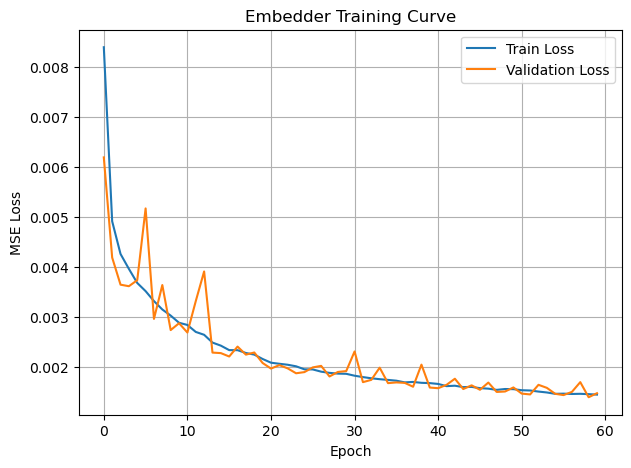

Embedder training complete.


In [7]:
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

criterion = nn.MSELoss()

# Optimizer (paper uses Adam with lr=1e-4)
optimizer = optim.Adam(embedder.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 60

train_losses = []
val_losses = []

def evaluate_loss(dataloader):
    embedder.eval()
    total = 0
    with torch.no_grad():
        for cover, wm in dataloader:
            cover = cover.to(device)
            wm = wm.to(device)
            marked = embedder(cover, wm)
            loss = criterion(marked, cover)
            total += loss.item()
    embedder.train()
    return total / len(dataloader)

embedder.train()
for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    running_loss = 0

    for cover, wm in pbar:
        cover = cover.to(device)
        wm = wm.to(device)

        optimizer.zero_grad()

        # Forward pass
        # debug assert (will raise clear error if channels/shapes are wrong)
        assert cover.dim() == 4 and wm.dim() == 4, f"expected 4-D tensors, got {cover.dim()} and {wm.dim()}"
        assert cover.shape[1] == 1 and wm.shape[1] == 1, f"expected channels=1, got cover:{cover.shape} wm:{wm.shape}"
        assert cover.shape[2] == 128 and cover.shape[3] == 128, f"cover size wrong: {cover.shape}"
        assert wm.shape[2] == 32 and wm.shape[3] == 32, f"wm size wrong: {wm.shape}"

        marked = embedder(cover, wm)

        # Loss
        loss = criterion(marked, cover)

        # Backprop
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss   = evaluate_loss(test_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"\nEpoch {epoch+1}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

    # Save checkpoi
    # nt each epoch
torch.save(embedder.state_dict(), "embedder_final.pth")
print("Final embedder model saved as embedder_final.pth")


# Plot training curve
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Embedder Training Curve")
plt.legend()
plt.grid(True)
plt.show()

print("Embedder training complete.")


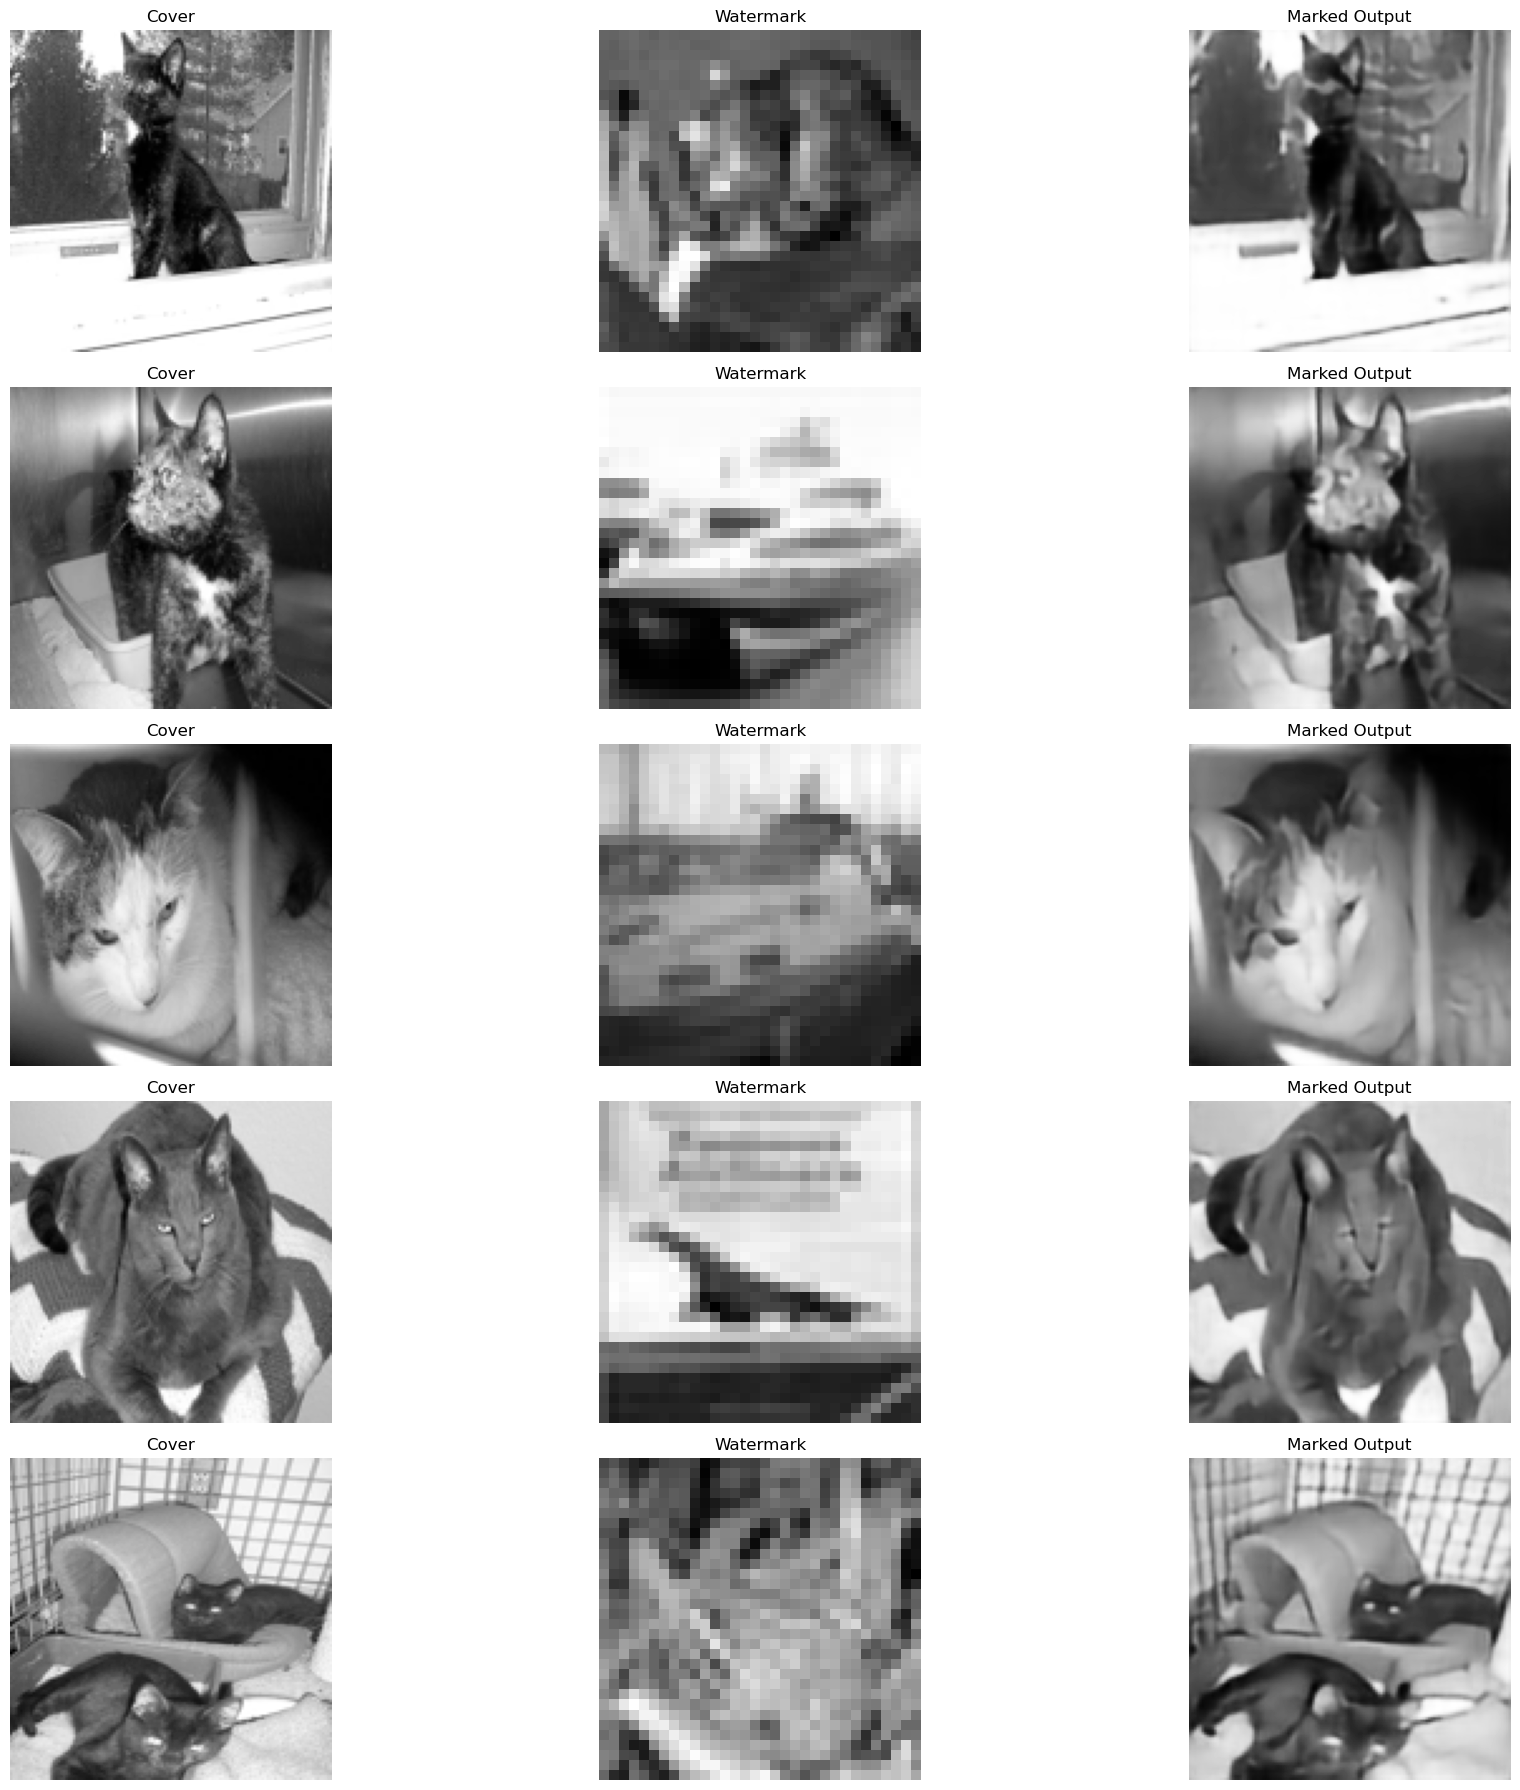

In [18]:
import matplotlib.pyplot as plt

# Load trained embedder weights
embedder.load_state_dict(torch.load("embedder_final.pth", map_location=device))
embedder.eval()

# Get a small test batch
cover_batch, wm_batch = next(iter(test_loader))
cover_batch = cover_batch.to(device)
wm_batch    = wm_batch.to(device)

# Generate marked images
with torch.no_grad():
    marked_batch = embedder(cover_batch, wm_batch)

# Convert tensors to numpy for display
def to_np(img):
    return img.squeeze().cpu().numpy()

num_show = cover_batch.size(0)  # show up to 5 samples

plt.figure(figsize=(20, 18))
for i in range(num_show):

    # Cover image
    plt.subplot(num_show, 3, i*3 + 1)
    plt.imshow(to_np(cover_batch[i]), cmap='gray')
    plt.title("Cover")
    plt.axis('off')

    # Watermark image
    plt.subplot(num_show, 3, i*3 + 2)
    plt.imshow(to_np(wm_batch[i]), cmap='gray')
    plt.title("Watermark")
    plt.axis('off')
    # Marked Image
    plt.subplot(num_show, 3, i*3 + 3)
    plt.imshow(to_np(marked_batch[i]), cmap='gray')
    plt.title("Marked Output")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
import torch.nn as nn

class ExtractorDecoder(nn.Module):
    def __init__(self, out_channels=1, base_channels=Num_kernels):
        super().__init__()

        self.dec = nn.Sequential(
            # input is [B, 4*base, 16,16]
            conv_block(base_channels*4, base_channels*2),
            conv_block(base_channels*2, base_channels*2),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 16→32
            conv_block(base_channels*2, base_channels),

            nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()   # final watermark in [0,1]
        )

    def forward(self, x):
        return self.dec(x)



class MarkedEncoder(nn.Module):
    def __init__(self, in_channels=1, base_channels=Num_kernels):
        super().__init__()

        self.enc = nn.Sequential(
            conv_block(in_channels, base_channels),
            conv_block(base_channels, base_channels),
            nn.MaxPool2d(2),        # 128→64

            conv_block(base_channels, base_channels*2),
            conv_block(base_channels*2, base_channels*2),
            nn.MaxPool2d(2),        # 64→32

            conv_block(base_channels*2, base_channels*4),
            conv_block(base_channels*4, base_channels*4),
            nn.MaxPool2d(2),        # 32→16
        )

    def forward(self, x):
        return self.enc(x)



class WatermarkExtractor(nn.Module):
    """
    Full extractor = encoder (marked image) + decoder (watermark).
    This recovers the 32x32 watermark from 128x128 marked image.
    """
    def __init__(self, base_channels=Num_kernels):
        super().__init__()
        self.enc_m = MarkedEncoder(in_channels=1, base_channels=base_channels)
        self.decoder = ExtractorDecoder(out_channels=1, base_channels=base_channels)

    def forward(self, marked):
        zm = self.enc_m(marked)        # encoded marked image [B,4*base,16,16]
        wm_rec = self.decoder(zm)      # recovered watermark [B,1,32,32]
        return wm_rec



# ============================================================
# Sanity test (run this after defining extractor)
# ============================================================

extractor = WatermarkExtractor(base_channels=Num_kernels).to(device)

dummy_marked = torch.randn(2,1,128,128).to(device)

with torch.no_grad():
    rec = extractor(dummy_marked)

print("Extractor output shape:", rec.shape)   # expected [2,1,32,32]


Extractor output shape: torch.Size([2, 1, 32, 32])


In [ ]:
# ============================================================
# CELL 6 — Train Watermark Extractor (Marked → Watermark)
# ============================================================

import torch.optim as optim

# Loss function
criterion_ex = nn.MSELoss()

# Optimizer for extractor
optimizer_ex = optim.Adam(extractor.parameters(), lr=1e-4)

# Number of epochs (start with 40–60)
extractor_epochs = 40

# To store losses for plotting
train_ex_losses = []
val_ex_losses = []


# ------------------------------------------------------------
# Helper function: evaluate extractor on test set
# ------------------------------------------------------------
def evaluate_extractor(dataloader):
    extractor.eval()
    total = 0
    with torch.no_grad():
        for cover, wm in dataloader:
            cover = cover.to(device)
            wm = wm.to(device)

            # Generate marked image using pretrained embedder
            marked = embedder(cover, wm)

            # Extract watermark from marked
            wm_rec = extractor(marked)

            # Compute loss vs. ground truth watermark
            loss = criterion_ex(wm_rec, wm)
            total += loss.item()

    extractor.train()
    return total / len(dataloader)



# ============================================================
# TRAINING LOOP
# ============================================================

extractor.train()

for epoch in range(extractor_epochs):

    pbar = tqdm(train_loader, desc=f"Extractor Epoch {epoch+1}/{extractor_epochs}")
    running_loss = 0

    for cover, wm in pbar:
        cover = cover.to(device)
        wm = wm.to(device)

        # Generate marked images through trained embedder
        with torch.no_grad():
            marked = embedder(cover, wm)

        optimizer_ex.zero_grad()

        # Extract watermark from marked image
        wm_rec = extractor(marked)

        # Loss = error between reconstructed watermark and real watermark
        loss = criterion_ex(wm_rec, wm)

        # Backprop
        loss.backward()
        optimizer_ex.step()

        running_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    # Epoch losses
    avg_train = running_loss / len(train_loader)
    avg_val   = evaluate_extractor(test_loader)

    train_ex_losses.append(avg_train)
    val_ex_losses.append(avg_val)

    print(f"\nEpoch {epoch+1}: Extractor Train Loss = {avg_train:.6f}, Val Loss = {avg_val:.6f}")



# ============================================================
# SAVE FINAL MODEL
# ============================================================

torch.save(extractor.state_dict(), "extractor_final.pth")
print("Extractor training complete. Saved as extractor_final.pth")




Extractor Epoch 1/40: 100%|██████████| 312/312 [08:59<00:00,  1.73s/it, loss=0.0419]



Epoch 1: Extractor Train Loss = 0.046030, Val Loss = 0.044546


Extractor Epoch 2/40: 100%|██████████| 312/312 [08:18<00:00,  1.60s/it, loss=0.0339]



Epoch 2: Extractor Train Loss = 0.040687, Val Loss = 0.042379


Extractor Epoch 3/40: 100%|██████████| 312/312 [07:56<00:00,  1.53s/it, loss=0.0379]



Epoch 3: Extractor Train Loss = 0.038519, Val Loss = 0.041550


Extractor Epoch 4/40: 100%|██████████| 312/312 [07:57<00:00,  1.53s/it, loss=0.0387]



Epoch 4: Extractor Train Loss = 0.037214, Val Loss = 0.040468


Extractor Epoch 5/40: 100%|██████████| 312/312 [07:44<00:00,  1.49s/it, loss=0.0378]



Epoch 5: Extractor Train Loss = 0.036043, Val Loss = 0.039488


Extractor Epoch 6/40: 100%|██████████| 312/312 [08:46<00:00,  1.69s/it, loss=0.0337]



Epoch 6: Extractor Train Loss = 0.035326, Val Loss = 0.042828


Extractor Epoch 7/40: 100%|██████████| 312/312 [08:26<00:00,  1.62s/it, loss=0.035] 



Epoch 7: Extractor Train Loss = 0.034574, Val Loss = 0.037665


Extractor Epoch 8/40: 100%|██████████| 312/312 [08:32<00:00,  1.64s/it, loss=0.0362]



Epoch 8: Extractor Train Loss = 0.033866, Val Loss = 0.037325


Extractor Epoch 9/40: 100%|██████████| 312/312 [09:43<00:00,  1.87s/it, loss=0.0319]



Epoch 9: Extractor Train Loss = 0.033431, Val Loss = 0.037526


Extractor Epoch 10/40: 100%|██████████| 312/312 [08:57<00:00,  1.72s/it, loss=0.0293]



Epoch 10: Extractor Train Loss = 0.032819, Val Loss = 0.038169


Extractor Epoch 11/40: 100%|██████████| 312/312 [08:30<00:00,  1.64s/it, loss=0.0332]



Epoch 11: Extractor Train Loss = 0.032305, Val Loss = 0.036970


Extractor Epoch 12/40: 100%|██████████| 312/312 [09:50<00:00,  1.89s/it, loss=0.0319]



Epoch 12: Extractor Train Loss = 0.032022, Val Loss = 0.037238


Extractor Epoch 13/40: 100%|██████████| 312/312 [08:20<00:00,  1.60s/it, loss=0.0343]



Epoch 13: Extractor Train Loss = 0.031635, Val Loss = 0.036097


Extractor Epoch 14/40: 100%|██████████| 312/312 [08:01<00:00,  1.54s/it, loss=0.0321]



Epoch 14: Extractor Train Loss = 0.031197, Val Loss = 0.039224


Extractor Epoch 15/40: 100%|██████████| 312/312 [08:43<00:00,  1.68s/it, loss=0.0334]



Epoch 15: Extractor Train Loss = 0.031037, Val Loss = 0.036010


Extractor Epoch 16/40: 100%|██████████| 312/312 [09:00<00:00,  1.73s/it, loss=0.0265]



Epoch 16: Extractor Train Loss = 0.030551, Val Loss = 0.039124


Extractor Epoch 17/40: 100%|██████████| 312/312 [09:12<00:00,  1.77s/it, loss=0.0327]



Epoch 17: Extractor Train Loss = 0.030322, Val Loss = 0.037434


Extractor Epoch 18/40: 100%|██████████| 312/312 [07:46<00:00,  1.49s/it, loss=0.0261]



Epoch 18: Extractor Train Loss = 0.030052, Val Loss = 0.037395


Extractor Epoch 19/40: 100%|██████████| 312/312 [08:14<00:00,  1.58s/it, loss=0.0284]



Epoch 19: Extractor Train Loss = 0.029883, Val Loss = 0.035221


Extractor Epoch 20/40: 100%|██████████| 312/312 [08:06<00:00,  1.56s/it, loss=0.0288]



Epoch 20: Extractor Train Loss = 0.029484, Val Loss = 0.034701


Extractor Epoch 21/40: 100%|██████████| 312/312 [07:20<00:00,  1.41s/it, loss=0.0321]



Epoch 21: Extractor Train Loss = 0.029233, Val Loss = 0.036298


Extractor Epoch 22/40: 100%|██████████| 312/312 [08:12<00:00,  1.58s/it, loss=0.0288]



Epoch 22: Extractor Train Loss = 0.029119, Val Loss = 0.038125


Extractor Epoch 23/40: 100%|██████████| 312/312 [09:22<00:00,  1.80s/it, loss=0.0269]



Epoch 23: Extractor Train Loss = 0.028701, Val Loss = 0.035308


Extractor Epoch 24/40: 100%|██████████| 312/312 [08:38<00:00,  1.66s/it, loss=0.0283]



Epoch 24: Extractor Train Loss = 0.028601, Val Loss = 0.038259


Extractor Epoch 25/40: 100%|██████████| 312/312 [07:54<00:00,  1.52s/it, loss=0.0269]



Epoch 25: Extractor Train Loss = 0.028399, Val Loss = 0.035176


Extractor Epoch 26/40: 100%|██████████| 312/312 [08:23<00:00,  1.61s/it, loss=0.0244]



Epoch 26: Extractor Train Loss = 0.028222, Val Loss = 0.041636


Extractor Epoch 27/40: 100%|██████████| 312/312 [08:19<00:00,  1.60s/it, loss=0.0283]



Epoch 27: Extractor Train Loss = 0.027958, Val Loss = 0.034830


Extractor Epoch 28/40: 100%|██████████| 312/312 [08:25<00:00,  1.62s/it, loss=0.0294]



Epoch 28: Extractor Train Loss = 0.027719, Val Loss = 0.034753


Extractor Epoch 29/40: 100%|██████████| 312/312 [08:07<00:00,  1.56s/it, loss=0.0259]



Epoch 29: Extractor Train Loss = 0.027857, Val Loss = 0.036963


Extractor Epoch 30/40: 100%|██████████| 312/312 [09:27<00:00,  1.82s/it, loss=0.0284]



Epoch 30: Extractor Train Loss = 0.027476, Val Loss = 0.039333


Extractor Epoch 31/40: 100%|██████████| 312/312 [08:25<00:00,  1.62s/it, loss=0.0262]



Epoch 31: Extractor Train Loss = 0.027221, Val Loss = 0.036362


Extractor Epoch 32/40: 100%|██████████| 312/312 [08:40<00:00,  1.67s/it, loss=0.0292]



Epoch 32: Extractor Train Loss = 0.027251, Val Loss = 0.034620


Extractor Epoch 33/40: 100%|██████████| 312/312 [08:44<00:00,  1.68s/it, loss=0.027] 



Epoch 33: Extractor Train Loss = 0.027132, Val Loss = 0.036055


Extractor Epoch 34/40: 100%|██████████| 312/312 [09:08<00:00,  1.76s/it, loss=0.0251]



Epoch 34: Extractor Train Loss = 0.026789, Val Loss = 0.034980


Extractor Epoch 35/40: 100%|██████████| 312/312 [18:39<00:00,  3.59s/it, loss=0.0232]   



Epoch 35: Extractor Train Loss = 0.026522, Val Loss = 0.034001


Extractor Epoch 36/40: 100%|██████████| 312/312 [08:26<00:00,  1.62s/it, loss=0.0241]



Epoch 36: Extractor Train Loss = 0.026576, Val Loss = 0.034958


Extractor Epoch 37/40: 100%|██████████| 312/312 [08:10<00:00,  1.57s/it, loss=0.0248]



Epoch 37: Extractor Train Loss = 0.026462, Val Loss = 0.034290


Extractor Epoch 38/40: 100%|██████████| 312/312 [07:34<00:00,  1.46s/it, loss=0.0281]



Epoch 38: Extractor Train Loss = 0.026267, Val Loss = 0.036925


Extractor Epoch 39/40: 100%|██████████| 312/312 [07:00<00:00,  1.35s/it, loss=0.0289]



Epoch 39: Extractor Train Loss = 0.026223, Val Loss = 0.040915


Extractor Epoch 40/40: 100%|██████████| 312/312 [08:18<00:00,  1.60s/it, loss=0.0264]



Epoch 40: Extractor Train Loss = 0.026242, Val Loss = 0.034550
Extractor training complete. Saved as extractor_final.pth


NameError: name 'plt' is not defined

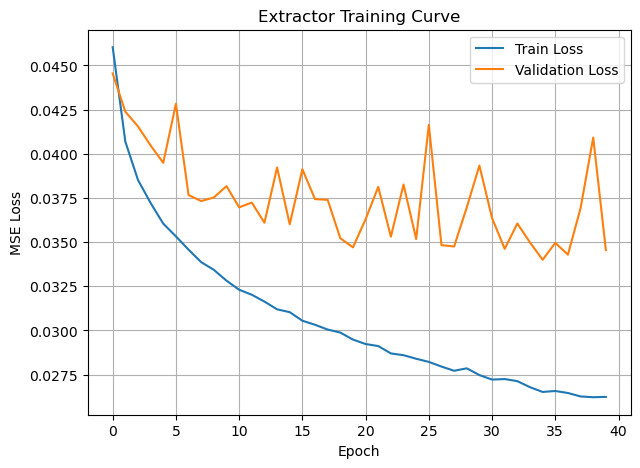

In [10]:
# ============================================================
# PLOT TRAINING CURVE
# ============================================================

import matplotlib.pyplot as plt


plt.figure(figsize=(7,5))
plt.plot(train_ex_losses, label="Train Loss")
plt.plot(val_ex_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Extractor Training Curve")
plt.legend()
plt.grid(True)
plt.show()


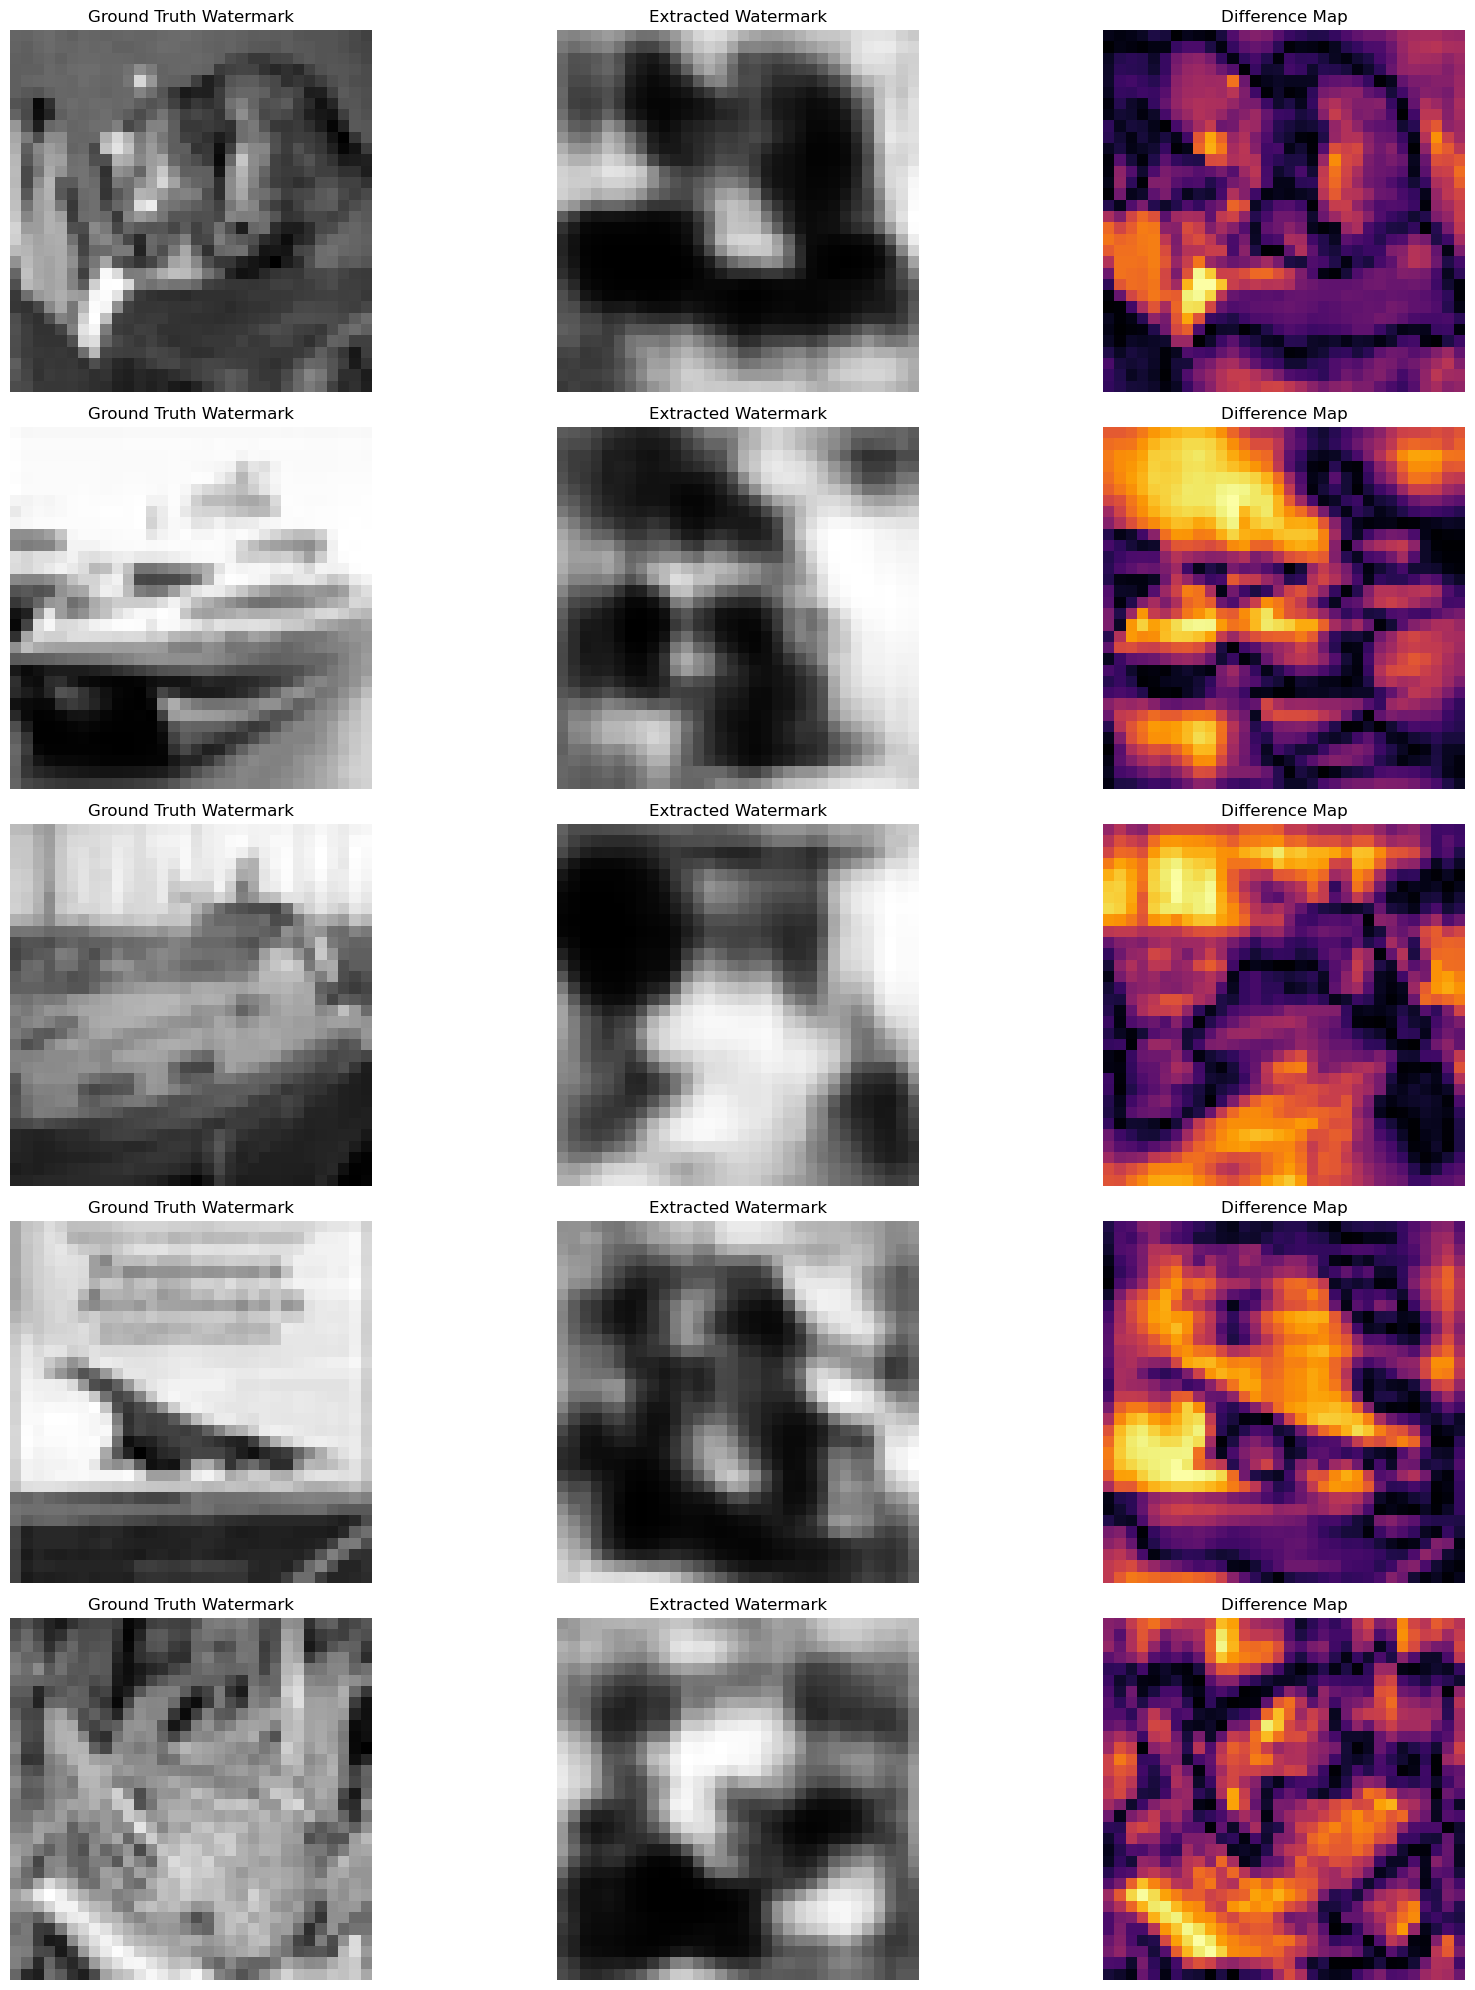


=== Extraction Quality Metrics ===

Sample 1 →  PSNR: 9.3687,   SSIM: -0.0031
Sample 2 →  PSNR: 7.0897,   SSIM: -0.0817
Sample 3 →  PSNR: 7.7120,   SSIM: 0.1621
Sample 4 →  PSNR: 8.5171,   SSIM: 0.0414
Sample 5 →  PSNR: 9.4756,   SSIM: -0.0425

Evaluation complete.


In [12]:
# ============================================================
# CELL 7 — Watermark Extraction Visualization + PSNR + SSIM
# ============================================================

from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# Load the trained extractor
extractor.load_state_dict(torch.load("extractor_final.pth", map_location=device))
extractor.eval()

# Load the trained embedder (needed to generate marked images)
embedder.load_state_dict(torch.load("embedder_final.pth", map_location=device))
embedder.eval()


# Helper function: convert tensor to numpy image
def to_np(img):
    return img.squeeze().detach().cpu().numpy()



# ------------------------------------------------------------
# Get a test batch
# ------------------------------------------------------------
cover_batch, wm_batch = next(iter(test_loader))
cover_batch = cover_batch.to(device)
wm_batch = wm_batch.to(device)


# ------------------------------------------------------------
# Generate marked images
# ------------------------------------------------------------
with torch.no_grad():
    marked_batch = embedder(cover_batch, wm_batch)


# ------------------------------------------------------------
# Extract watermarks
# ------------------------------------------------------------
with torch.no_grad():
    wm_rec_batch = extractor(marked_batch)



# ============================================================
# VISUALIZATION
# ============================================================

num_show = min(6, cover_batch.size(0))   # Show up to 6 examples

plt.figure(figsize=(18, 4*num_show))

for i in range(num_show):

    gt = to_np(wm_batch[i])          # Ground truth watermark
    rec = to_np(wm_rec_batch[i])     # Reconstructed watermark
    diff = abs(gt - rec)             # Difference map
    
    # ---- Ground Truth ----
    plt.subplot(num_show, 3, i*3 + 1)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth Watermark")
    plt.axis('off')

    # ---- Reconstructed ----
    plt.subplot(num_show, 3, i*3 + 2)
    plt.imshow(rec, cmap='gray')
    plt.title("Extracted Watermark")
    plt.axis('off')

    # ---- Difference ----
    plt.subplot(num_show, 3, i*3 + 3)
    plt.imshow(diff, cmap='inferno')
    plt.title("Difference Map")
    plt.axis('off')

plt.tight_layout()
plt.show()



# ============================================================
# PRINT PSNR + SSIM SCORES
# ============================================================

print("\n=== Extraction Quality Metrics ===\n")

for i in range(num_show):
    gt = to_np(wm_batch[i])
    rec = to_np(wm_rec_batch[i])
    
    psnr_score = psnr_metric(gt, rec, data_range=1.0)
    ssim_score = ssim_metric(gt, rec, data_range=1.0)

    print(f"Sample {i+1} →  PSNR: {psnr_score:.4f},   SSIM: {ssim_score:.4f}")

print("\nEvaluation complete.")
